In [1]:
# Library imports
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tools
from train import generate_graph, train

# Reproducibility

The results of this notebook are not deterministic. Therefore, the results from a previous run are loaded here. Run this cell instead of the cells in the following section ('Experiment Code') in order to generate an identical plot to the accompanying paper in the 'Plot' section at the end of the notebook.

In [ ]:
# Load the previous results
with open('saved_results//hyperparameters_days_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Experiment Code

In [2]:
# Fix random seed for reproducibility
np.random.seed(628496)

# Stop on errors
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
results = {}
repeats = 4

for total_days in tqdm(range(60, 480, 60)):
    # Repeat a number of times, to reduce variability in output
    times = 0
    log_likelihoods = 0
    for repeat in range(repeats):
        # Generate the synthetic data with a different length of accounting period
        edges_by_day, last_day, raw_accounts = \
            tools.simulate_many_nodes(
                total_days=total_days
            )

        # Count the number of generated edges
        count_edges = sum(len(day) for day in edges_by_day.values())

        # Start recording the time
        start_time = time.time()

        # Create a graph object
        graph = generate_graph(
            raw_accounts=raw_accounts,
            edges_by_day=edges_by_day,
            last_day=last_day,
            node_dimension=32,
            graph_kwords={
                'causal_learning_rate': 0.01,
                'weight_regularisation_rate': 10**(-5),
                'spontaneous_regularisation_rate': 10**(-7)
            }
        )

        # Train
        probabilities = train(
            graph, edges_by_day, last_day, iterations=50,
            plot_log_likelihood=False, use_tqdm=False,
            spontaneous_learning_startpoint=25
            )

        # Stop the timer
        end_time = time.time()

        # Add the results to the running total for this number of days
        times += (end_time-start_time)/60
        log_likelihoods += probabilities[-1]

    # Record the average results
    results[total_days] = {
        'time_taken': times/repeats,
        'log_likelihood': log_likelihoods/repeats
    }

100%|██████████| 7/7 [43:06<00:00, 369.45s/it]


In [4]:
# Save the results
with open('saved_results//hyperparameters_days_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Plot

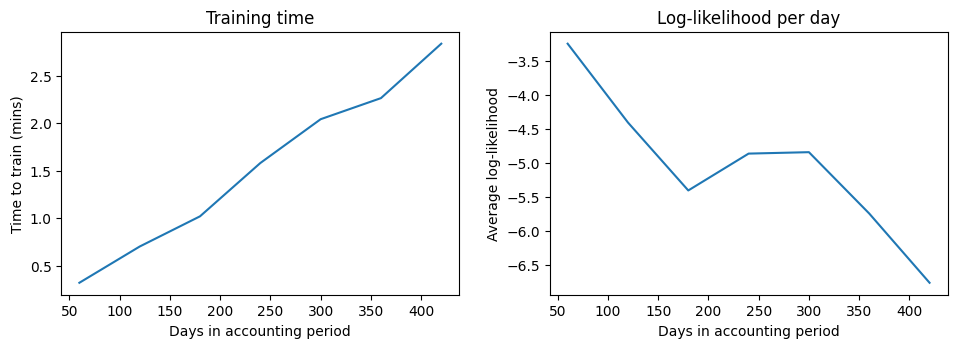

In [6]:
# Create the x-axis data
all_total_days = np.array(list(total_days for total_days in results.keys()))
all_total_days.sort()

# Create the subplots
fig, axes = plt.subplots(1, 2)

fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(3)

# Create the y-axis data for the time taken
times = np.array([results[total_days]['time_taken'] for total_days in all_total_days])

# Plot the time taken
axes[0].plot(
    all_total_days, times
)

axes[0].set_xlabel('Days in accounting period')
axes[0].set_ylabel('Time to train (mins)')
axes[0].set_title('Training time')

# Create the y-axis data for the log-likelihood per day
log_likelihoods = np.array([results[total_days]['log_likelihood']/total_days for total_days in all_total_days])

# Plot the log-likelihood
axes[1].plot(
    all_total_days, log_likelihoods
)

#axes[1].set_ylim((-2.0, -1.4))

axes[1].set_xlabel('Days in accounting period')
axes[1].set_ylabel('Average log-likelihood')
axes[1].set_title('Log-likelihood per day')

plt.show()